# Mangle Spectra
----


In [1]:
# %matplotlib inline
%matplotlib notebook

from __future__ import print_function

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import os
import warnings
import copy

import numpy as np
import pandas as pd

from astropy.table import Table, Row, Column
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import interpolate

from lmfit import minimize, Parameters, fit_report

from collections import OrderedDict

import pycoco as pcc
import pyCoCo as pccsim

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim

plotdir = os.path.join(os.environ['PYPLOTDIR'], 'SESNePaper/')

In [2]:
def plot_mangledata(S, data_table, mS=False, xminorticks=250, yminorticks=0.1, show_lims=True, show_linear_extrap=True,
                    spl=False, spl_clamped=False, spl_wav=False, return_fig=False, m_upper=False, m_lower=False, 
                    c_upper=False, c_lower=False, ylim = False, frameon=True, units=True):
    """
    """
    
    pcc.setup_plot_defaults()
    xaxis_label_string = r'$\textnormal{Wavelength, Angstrom (\AA)}$'
    yaxis_label_string = r'$\textnormal{Fractional Throughput}$'
    if units:
        spec_yaxis_label_string = r'$\textnormal{Flux, erg s}^{-1}\textnormal{\AA}^{-1}\textnormal{cm}^{-2}$'
    else:
        spec_yaxis_label_string = r'$\textnormal{Flux, Scaled}$'
        
    yminorLocator = MultipleLocator(yminorticks)
    xminorLocator = MultipleLocator(xminorticks)

    #fig = plt.figure(figsize=[12, 6])
    fig = plt.figure(figsize=[8, 4])
    fig.subplots_adjust(left=0.09, bottom=0.13, top=0.95,
                        right=0.92, hspace=0, wspace=0)

    ax = fig.add_subplot(111)
    ax1 = ax.twinx()

    #     ax.plot(S.data['wavelength'], S.data['flux'], zorder = 0, label=r"$\textnormal{Spectrum}$")
    ax.plot(S.wavelength, S.flux, zorder=0, label=r"$\textnormal{Spectrum}$")

    ax.scatter(data_table["lambda_eff"], data_table["fitflux"], color=data_table["knot_colours"], label=None,
               marker="*", s=120)
    ax.scatter(data_table["lambda_eff"], data_table["spec_filterflux"], edgecolors=data_table["knot_colours"],
               label=None)
    if mS:
        ax.plot(mS.wavelength, mS.flux, zorder=0, label=r"$\textnormal{Mangled Spectrum}$")
        ax.scatter(data_table["lambda_eff"], data_table["mangledspec_filterflux"], edgecolors=data_table["knot_colours"],
                   label=None)
    if not spl_wav:
        spl_wav=S.wavelength
    if spl:
        ax.plot(spl_wav, spl(spl_wav), color = "Black", label=r"$\textnormal{Spline}$")
    if spl_clamped:
        ax.plot(spl_wav, spl_clamped(spl_wav), color = "Black", label=r"$\textnormal(Clamped Spline)$")

    if show_linear_extrap:
        ax.plot(S.data['wavelength'].data, m_upper * S.data['wavelength'].data + c_upper, color=pcc.hex["batman"], ls=":",
                label=None)
        ax.plot(S.data['wavelength'].data, m_lower * S.data['wavelength'].data + c_lower, color=pcc.hex["batman"], ls=":",
                label=None)

    for i, f in enumerate(data_table["filter_object"]):
        if isinstance(f, pcc.FilterClass):
            filter_label_string = r'$\textnormal{' + f.filter_name.replace("_", " ") + '}$'
            #             filter_label_string = r'$\textnormal{' + f.filter_name.decode().replace("_", " ") + '}$'


            if hasattr(f, "_plot_colour"):
                ax1.plot(f.wavelength, f.throughput, color=f._plot_colour,
                         lw=2, label=filter_label_string, alpha=0.5)
            else:
                ax1.plot(f.wavelength, f.throughput, lw=2, label=filter_label_string, alpha=0.5)

            if show_lims:
                try:
                    ax1.plot([f._upper_edge, f._upper_edge], [0, 1.1],
                             lw=1.5, alpha=0.5, ls=':',
                             color=f._plot_colour, zorder=0, )
                    ax1.plot([f._lower_edge, f._lower_edge], [0, 1.1],
                             lw=1.5, alpha=0.5, ls=':',
                             color=f._plot_colour, zorder=0, )
                except:
                    print("Failed")

    default_xlims = ax1.get_xlim()
    ax1.plot(default_xlims, [0, 0], color=pcc.hex["black"], ls=":")
    ax1.set_xlim(default_xlims)
    ax1.set_xlim(S.min_wavelength * 0.95, S.max_wavelength * 1.05)
    ax1.set_ylim([0, 1.05])
    if ylim:
        ax.set_ylim(ylim)
        
    ax1.set_xlabel(xaxis_label_string)
    ax.set_xlabel(xaxis_label_string)
    ax1.set_ylabel(yaxis_label_string)

    ax1.yaxis.set_minor_locator(yminorLocator)
    ax1.xaxis.set_minor_locator(xminorLocator)

    ## https://stackoverflow.com/a/10129461
    lines, labels = ax.get_legend_handles_labels()
    lines1, labels1 = ax1.get_legend_handles_labels()
    #     lines2, labels2 = ax2.get_legend_handles_labels()

    # plot_legend = ax1.legend(loc = [1.,0.0], scatterpoints = 1,
    #     ax.legend(lines + lines1 + lines2,labels + labels1 + labels2, loc=0, scatterpoints=1,
    ax.legend(lines + lines1, labels + labels1, loc=0, scatterpoints=1,
              numpoints=1, frameon=frameon, fontsize=12)

    ax.set_ylabel(spec_yaxis_label_string)
    if return_fig:
        return fig
    else:
        plt.show()
    pass


def applymangle(params, SpectrumObject):

    MangledSpectrumObject = copy.deepcopy(SpectrumObject)
    paramlist = np.array([params[key].value for key in params.keys()])
    print("params:", paramlist)

    weights = np.append(np.append(1.0, paramlist), 1.0)
    print("weights:", weights)

    # SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights)
    SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights, bc_type = "clamped")

    plt.plot(MangledSpectrumObject.wavelength, SplObj(MangledSpectrumObject.wavelength))
    plt.scatter(data_table["lambda_eff"], weights)

    plt.show()

    MangledSpectrumObject.flux = MangledSpectrumObject.flux * SplObj(MangledSpectrumObject.wavelength)

    return MangledSpectrumObject


def calculate_fluxes(data_table, S):
    for i, f in enumerate(data_table["filter_object"]):
        column = []
        if isinstance(f, pcc.FilterClass):
            mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=S)
            print(data_table["spec_filterflux"][i], mangledspec_filterflux)
            # data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
            column.append(mangledspec_filterflux)

        else:
            pass
    return column


## Load in SN

<IPython.core.display.Javascript object>


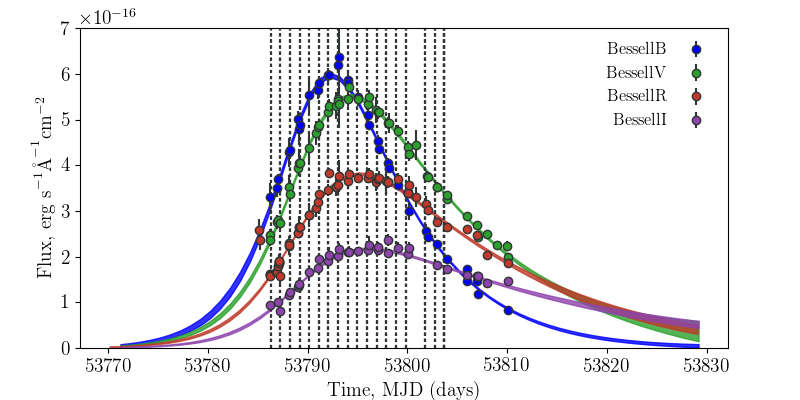

In [3]:
snname = "SN2006aj"
spec_filename = "SN2006aj_vlt_2006_03_10_z0.dat"
spec_mjd = 53803.0

verbose = False
plot = True
sn = pcc.SNClass(snname)
sn.load_phot(verbose=False)
sn.load_list("/Users/berto/Code/CoCo/lists/" + snname + ".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/" + snname + ".dat")
sn.check_overlaps()

spec_dir = "/Users/berto/Code/CoCo/data/spec/" + snname + "/"
S = pcc.SpectrumClass()
S.load(filename=spec_filename, directory=spec_dir)

sn.plot_lc(multiplot=False)

## Set up the Mangle
---
We need to know several things before we start - what filters we want to mangle, what the spectrophotometry is at the start, what is the flux that we want, and where the anchors are going to be.

First we should take a look at how far off the original spectrophotometry is compared to the best fit.

In [4]:
# filters = ["SDSS_g", "SDSS_r", "SDSS_i","SDSS_z"]
filters = ["BessellB", "BessellV", "BessellR", "BessellI"]

rows = OrderedDict()
filter_dict = OrderedDict()

for i, f in enumerate(filters):
    filter_dict[f] = pcc.kcorr.load_filter(os.path.join(pcc._default_filter_dir_path, f + ".dat"))
    filter_dict[f].calculate_edges()
    #     filter_dict[f].calculate_edges_zero()

    fit_flux = sn.lcfit.spline[f](spec_mjd)

    sn.phot.data_filters[f].resample_response(new_wavelength=S.wavelength)
    S_filter_flux = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S)
    S_filter_flux_no_area = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S,
                                                          correct_for_area=False)
    mS_filter_flux = np.NaN

    rows[f] = (fit_flux, S_filter_flux, S_filter_flux_no_area)
    if i == 0:
        data_table = Table(names=("filter", "fitflux", "spec_filterflux", "mangledspec_filterflux", "filter_object", "mask"),
            dtype=('S12', 'f4', 'f4', 'f4', object, bool))
    data_table.add_row((f, fit_flux, S_filter_flux, mS_filter_flux, filter_dict[f], True))

data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask
bytes12,float32,float32,float32,object,bool
BessellB,2.22585e-16,5.17334e-17,nan,<pycoco.classes.FilterClass object at 0x113981c88>,True
BessellV,3.57507e-16,1.24878e-16,nan,<pycoco.classes.FilterClass object at 0x113981dd8>,True
BessellR,2.88377e-16,1.08969e-16,nan,<pycoco.classes.FilterClass object at 0x1138e39b0>,True
BessellI,1.8346e-16,6.12809e-17,nan,<pycoco.classes.FilterClass object at 0x1138d7278>,True


So the fitflux is brighter than the specflux by something like an order of two, apart from B-band (this will become important later). 

## Check Boundaries
---
The next step is to remove any filters that do not overlap with the spectra.

In [5]:
for i, f in enumerate(data_table["filter_object"]):
    ## Test extent
    bool_uncontained = np.logical_or(f._lower_edge < S.min_wavelength, f._upper_edge > S.max_wavelength)
    if verbose: print(bool_uncontained)
    if bool_uncontained:
        data_table = data_table[np.where(data_table["filter"] != pcc.utils.b(f.filter_name))]

knot_colours = [j._plot_colour for j in data_table["filter_object"] if hasattr(j, "_plot_colour")]
data_table.add_column(Column(knot_colours, name="knot_colours"))
data_table["lambda_eff"] = [i.lambda_effective.value for i in data_table["filter_object"]]
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,2.22585e-16,5.17334e-17,nan,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,3.57507e-16,1.24878e-16,nan,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,2.88377e-16,1.08969e-16,nan,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,1.8346e-16,6.12809e-17,nan,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198


Great, none got thrown out. Let's take a look at what we have. Below is a plot of the spectrum (blue), the spectrophotometry (blue-faced points), the filters and their corresponding fitflux, shon as stars. The vertical dotted lines show the region of the filter response that contains less than 3% of the total throughput, which we can consider the "edge" of the filter. 

<IPython.core.display.Javascript object>


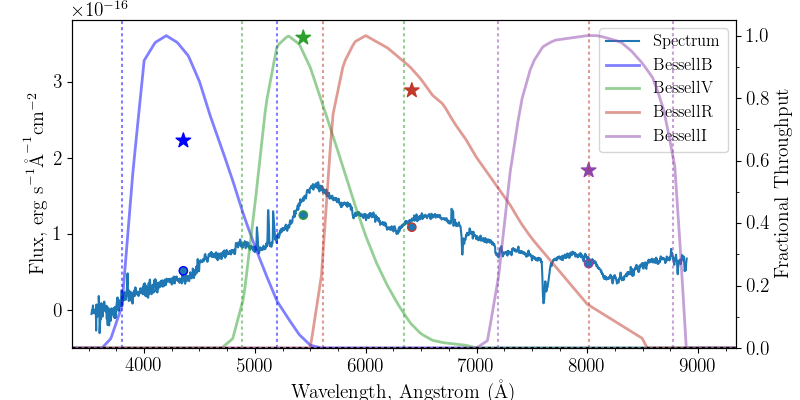

In [6]:
plot_mangledata(S, data_table, show_linear_extrap=False)

# Scaling the Spectra
---

From experience, fitting routines are more stable with values around unity. Values of ~10e-16 don't fit the bill, so I'm going to scale. The scaling I will do will adjust the B-Band spectrophotometry to match the flux from the fit. This will be done in two steps - one to get the spectrum in units of "B-Flux" (`scale-factor`) and then to match the spec and observed fluxes (`norm-factor`).

In [7]:
## Normalise data_table
# "wanted flux"
w = 0
scale_factor = 1. / data_table[w]["fitflux"]
print("Scale Factor", scale_factor)
norm_factor = data_table[w]["fitflux"] / data_table[w]["spec_filterflux"]
print("norm factor", norm_factor)
data_table["fitflux"] = data_table["fitflux"] * scale_factor
# "spec flux"
data_table["spec_filterflux"] = data_table["spec_filterflux"] * scale_factor
print("scaled ",)
nS = copy.deepcopy(S)
S.flux = S.flux * scale_factor
S.flux = S.flux * norm_factor
S.scale_factor = scale_factor
S.norm_factor = norm_factor
data_table

Scale Factor 4.49265800237e+15
norm factor 4.30255
scaled 


filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,1.0,0.23242,nan,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,1.60616,0.561035,nan,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,1.29558,0.489561,nan,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,0.824223,0.275314,nan,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198


In [8]:
print("normalised")
data_table["spec_filterflux"] = data_table["spec_filterflux"] * norm_factor
data_table

normalised


filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,1.0,1.0,nan,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,1.60616,2.41388,nan,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,1.29558,2.10636,nan,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,0.824223,1.18455,nan,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198


Ok, great, let's take a look at what that has done to the plot:

<IPython.core.display.Javascript object>


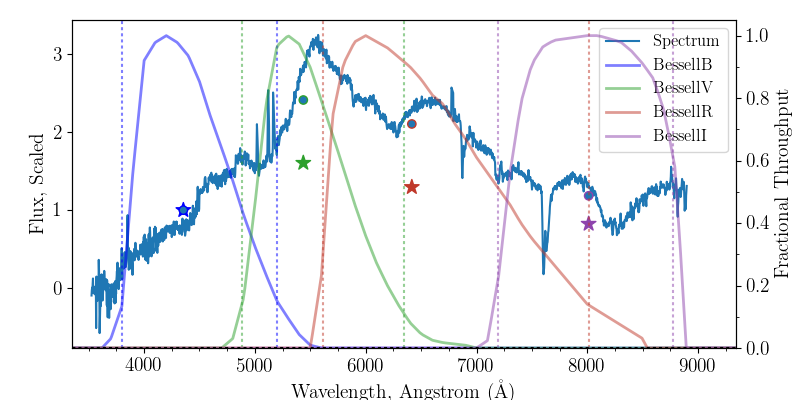

In [9]:
plot_mangledata(S, data_table, show_linear_extrap=False, units=False)

The specphot points now lie *above* those of the fit for the filters other than Bessell B. 

## Anchor Points
___
The mangling function we will use in this example is a cubic spline ([see here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)). To make sure we have reasonable behaviour all the way out to the edges of the wavelength range covered by the filters, we will anchor the  spline to two knots, one blueward of the first filter and one redward of the last filter, by 100 Angstroms. In some implementations, these anchors can move up and down during the minimisation. To set the _initial_ position, we can just linearly extrapolate from the two nearest filters.

In [10]:
## Lower
anchor_min_wavelength = np.nanmin([i._lower_edge for i in data_table["filter_object"]]) - 100
## x1-x2
dx = data_table["lambda_eff"][0] - data_table["lambda_eff"][1]
if verbose: print(dx)
## y1 - y2
dy = data_table["fitflux"][0] - data_table["fitflux"][1]
if verbose: print(dy)
##
m_lower = dy / dx
c_lower = data_table["fitflux"][0] - m_lower * data_table["lambda_eff"][0]
if verbose: print(m_lower, c_lower)

## Upper
anchor_max_wavelength = np.nanmax([i._upper_edge for i in data_table["filter_object"]]) + 100
## x1-x2
dx = data_table["lambda_eff"][-2] - data_table["lambda_eff"][-1]
if verbose: print(dx)
## y1 - y2
dy = data_table["fitflux"][-2] - data_table["fitflux"][-1]
if verbose: print(dy)
##
m_upper = dy / dx
c_upper = data_table["fitflux"][-2] - m_upper * data_table["lambda_eff"][-2]
if verbose: print(m_upper, c_upper)

spl_wav = S.data['wavelength'][np.logical_and(S.data['wavelength'] >= anchor_min_wavelength, S.data['wavelength'] <= anchor_max_wavelength)]

data_table.add_row(("lower_anchor", anchor_min_wavelength * m_lower + c_lower, anchor_min_wavelength * m_lower + c_lower,
                   anchor_min_wavelength * m_lower + c_lower, np.nan, False,
                   pcc.hex["batman"], anchor_min_wavelength))
data_table.add_row(("upper_anchor", anchor_max_wavelength * m_upper + c_upper, anchor_max_wavelength * m_upper + c_upper,
                   anchor_max_wavelength * m_upper + c_upper, np.nan, False,
                   pcc.hex["batman"], anchor_max_wavelength))

orig_data_table = data_table

data_table.add_index("lambda_eff")
data_table.sort()
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
lower_anchor,0.635323,0.635323,0.635323,nan,False,#303535,3703.17996744
BessellB,1.0,1.0,nan,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,1.60616,2.41388,nan,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,1.29558,2.10636,nan,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,0.824223,1.18455,nan,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198
upper_anchor,0.570223,0.570223,0.570223,nan,False,#303535,8871.44831678


<IPython.core.display.Javascript object>


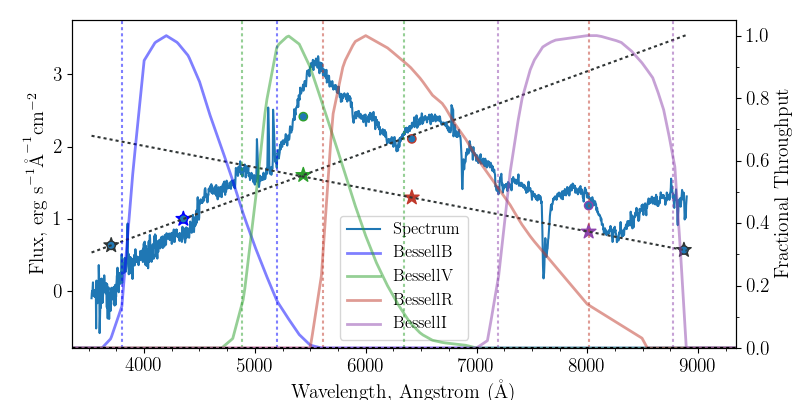

In [11]:
plot_mangledata(S, data_table, show_linear_extrap=True, c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower)

Looks good. We will now get rid of the NaN's in the mangledspec_filterflux column, by giving an initial flux. If we have done everything right, this integration will give us the same as the spec_filterflux column. Which, as we can see below, it does.

In [12]:
for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=S)
#         print(data_table["spec_filterflux"][i], mangledspec_filterflux)
        data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
    else:
        pass
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
lower_anchor,0.635323,0.635323,0.635323,nan,False,#303535,3703.17996744
BessellB,1.0,1.0,1.0,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,1.60616,2.41388,2.41388,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,1.29558,2.10636,2.10636,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,0.824223,1.18455,1.18455,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198
upper_anchor,0.570223,0.570223,0.570223,nan,False,#303535,8871.44831678


# Minimisation
___
We are now nearly ready to start the minimisation. For the minimisation we will be using `lmfit` ([see here](https://lmfit.github.io/lmfit-py/index.html)), and the default algorithm, levenberg-marquardt.

The parameter that we want to change is the relative scale factor of a knot, at the effective wavelength of each filter, which will be fit by a spline. The input spectrum will be multiplied by that spline, and the spectrophotometry re-calculated. The value we want to minimise is the residual between the spectrophotometry and the fit flux.

Let's go about taking a look at the function, and setting the initial parameter guesses.

In [13]:
original_spectrum_flux = data_table[data_table["mask"]]["spec_filterflux"].data
scaled_spectrum_flux = data_table[data_table["mask"]]["mangledspec_filterflux"].data
wanted_flux = data_table[data_table["mask"]]["fitflux"].data
wanted_filters = data_table[data_table["mask"]]["filter_object"].data

if len(scaled_spectrum_flux) == len(wanted_flux):
    params = Parameters()
    for i, flux_tuple in enumerate(zip(scaled_spectrum_flux, wanted_flux)):
        params.add(wanted_filters[i].filter_name, value=flux_tuple[1] / flux_tuple[0])
params

Parameters([('BessellB',
             <Parameter 'BessellB', 0.99999988, bounds=[-inf:inf]>),
            ('BessellV',
             <Parameter 'BessellV', 0.66538388, bounds=[-inf:inf]>),
            ('BessellR',
             <Parameter 'BessellR', 0.61507946, bounds=[-inf:inf]>),
            ('BessellI',
             <Parameter 'BessellI', 0.69580942, bounds=[-inf:inf]>)])

## The Minimisation Function
The function itself looks like this:


In [14]:
def manglemin(params, SpectrumObject, data_table, verbose=False, *args, **kwargs):
    """
    """
    MangledSpectrumObject = copy.deepcopy(SpectrumObject)
    paramlist = np.array([params[key].value for key in params.keys()])

    weights = np.append(np.append(1.0, paramlist), 1.0)

    # SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights)
    SplObj = interpolate.CubicSpline(data_table["lambda_eff"], weights, bc_type = "clamped")

    MangledSpectrumObject.flux = MangledSpectrumObject.flux * SplObj(MangledSpectrumObject.wavelength)

    specflux = np.array([pcc.calc_spectrum_filter_flux(filter_object=FilterObject, spectrum_object=MangledSpectrumObject) for
         FilterObject in data_table[data_table["mask"]]["filter_object"]])
    if verbose:
        print("params:", paramlist)
        print("weights:", weights)
        print("flux:", specflux)
        print("fitflux:", data_table[data_table["mask"]]["fitflux"].data)

    # return specflux - data_table[data_table["mask"]]["fitflux"]
    return data_table[data_table["mask"]]["fitflux"] - specflux

# Go!

In [15]:
out = minimize(manglemin, params, args=(S, data_table), kws=({"verbose":False}))
# out = minimize(manglemin, params, args=(S, data_table), epsfcn=1e-5)
print(fit_report(out))

[[Fit Statistics]]
    # function evals   = 13
    # data points      = 4
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = inf
    Akaike info crit   = -281.180
    Bayesian info crit = -283.635
[[Variables]]
    BessellB:   1.10572353 +/- inf      (inf%) (init= 0.9999999)
    BessellV:   0.64699429 +/- inf      (inf%) (init= 0.6653839)
    BessellR:   0.64483904 +/- inf      (inf%) (init= 0.6150795)
    BessellI:   0.64134082 +/- inf      (inf%) (init= 0.6958094)


Good - something happened! The initial guesses were good, so the weighting hasn't moved too far. Let's take a look at the result, and calculate the final mangle.

In [16]:
paramlist = np.array([out.params[key].value for key in out.params.keys()])
weights = np.append(np.append(1.0, paramlist), 1.0)
final_spl = interpolate.CubicSpline(data_table["lambda_eff"], weights, bc_type = "clamped")
mS = copy.deepcopy(S)
mS.flux = mS.flux*final_spl(mS.wavelength)

verbose = False
for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=mS)
        if verbose: print(data_table["spec_filterflux"][i], data_table["fitflux"][i], mangledspec_filterflux)
        data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
data_table

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
lower_anchor,0.635323,0.635323,0.635323,nan,False,#303535,3703.17996744
BessellB,1.0,1.0,1.0,<pycoco.classes.FilterClass object at 0x113981c88>,True,#0000ff,4354.41054934
BessellV,1.60616,2.41388,1.60616,<pycoco.classes.FilterClass object at 0x113981dd8>,True,#2ca02c,5436.8698117
BessellR,1.29558,2.10636,1.29558,<pycoco.classes.FilterClass object at 0x1138e39b0>,True,#c0392b,6416.11806798
BessellI,0.824223,1.18455,0.824223,<pycoco.classes.FilterClass object at 0x1138d7278>,True,#8e44ad,8011.65864198
upper_anchor,0.570223,0.570223,0.570223,nan,False,#303535,8871.44831678


Fantastic, the mangled spectrum spectrophotometry matches that of the fit. Let's look!

<IPython.core.display.Javascript object>


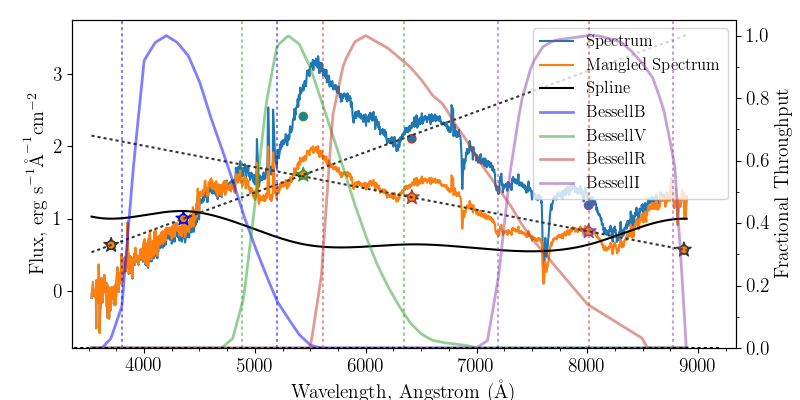

In [17]:
plot_mangledata(S, data_table, mS=mS, spl = final_spl, show_linear_extrap=True,
                c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower,)

# Getting Back to 'Sensible' Units
___

Luckily we kept the scale factors down the back of the digital sofa, as class variables accessable as methods in our `SpectrumClass` instance, `S`.

In [18]:
print("Scale Factor is:", S.scale_factor)
print("Norm Factor is:", S.norm_factor)

Scale Factor is: 4.49265800237e+15
Norm Factor is: 4.30255


In [ ]:


for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=mS)
        print(data_table["spec_filterflux"][i], data_table["fitflux"][i], mangledspec_filterflux)

In [ ]:
np.nanmax(mS.flux)